In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import time as tm
from scipy.stats import norm, lognorm
import pandas as pd


# Probabilità Condizionata e Derivazione dell'Equazione di Bayes

La probabilità condizionata è un concetto fondamentale nella teoria della probabilità e costituisce la base per la derivazione dell'equazione di Bayes.

## Probabilità Condizionata

La probabilità condizionata di un evento $A$ dato un altro evento $B$ (con $P(B) > 0$) è definita come:

$$
P(A|B) = \frac{P(A \cap B)}{P(B)}
$$

Questa espressione descrive la probabilità che l'evento $A$ si verifichi, sapendo che l'evento $B$ si è già verificato.

## Derivazione dell'Equazione di Bayes

Per derivare l'equazione di Bayes, partiamo dalla definizione di probabilità condizionata. Consideriamo due eventi $A$ e $B$ con $P(A) > 0$ e $P(B) > 0$. Possiamo scrivere la probabilità condizionata di $B$ dato $A$ e di $A$ dato $B$ come segue:

$$
P(B|A) = \frac{P(A \cap B)}{P(A)}
$$

$$
P(A|B) = \frac{P(A \cap B)}{P(B)}
$$

Dato che $P(A \cap B) = P(B \cap A)$, possiamo eguagliare i numeratori delle due espressioni:

$$
P(B|A) \cdot P(A) = P(A|B) \cdot P(B)
$$

Risolvendo per $P(A|B)$, otteniamo l'equazione di Bayes:

$$
P(A|B) = \frac{P(B|A) \cdot P(A)}{P(B)}
$$

### Interpretazione

L'equazione di Bayes ci permette di aggiornare la probabilità di un evento $A$ in base alla presenza di un nuovo evento $B$. In altre parole, ci fornisce un modo per aggiornare le nostre credenze iniziali (probabilità a priori) in base a nuove informazioni o evidenze.

Se infatti sostituiamo ad $A$ i parametri $p$ di un modello $M$, ed a $B$ i dati osservati $d$, l'Eq. di sopra si traduce in:

$$
P(p|d M) = \frac{P(d|p M) \cdot P(p|M)}{P(d|M)}
$$


### Esercizio 1

Supporre che un set di misure sia associato ad un processo Gaussiano, con valore medio e deviazione standard dato dall'errore associato. Calcolare il posterior del valore medio  di un campione di misura. 



In [3]:
data = pd.read_csv('Esercizio1.csv')

In [4]:
data

,Altezza,Errore
0,177.0,3.6
1,175.3,4.0
2,176.1,2.0
3,175.2,0.4
4,174.8,4.9
5,165.6,3.6
6,171.0,4.5
7,171.1,3.0
8,168.2,3.1
9,171.6,3.4


# Esercizio 2
Supporre che la massa dei neutrini sia data dalla differenza di due misure M1 e M2 con errore gaussiano su M1 e M2.


In [5]:
data = pd.read_csv('Esercizio2.csv')

# Algoritmo EMCEE

L'algoritmo `emcee` è un'implementazione efficiente del campionamento Markov Chain Monte Carlo (MCMC) specificamente progettato per l'analisi bayesiana. È particolarmente utile in astrofisica e altre scienze computazionali per l'ottimizzazione e l'inferenza statistica.

## Caratteristiche Principali

- `emcee` utilizza un approccio "ensemble sampling" per migliorare l'efficienza del campionamento, specialmente in problemi con molteplici dimensioni.
- È progettato per essere intuitivo e facile da integrare con le librerie scientifiche esistenti in Python.
- Può essere utilizzato per un'ampia gamma di problemi statistici e si adatta bene a funzioni di probabilità complesse.

## Funzionamento

L'algoritmo si basa su un insieme di "caminatori" ("walkers") che esplorano lo spazio dei parametri. Ogni walker si muove casualmente, ma in una maniera che dipende dalla posizione degli altri walker nell'insieme. Questo approccio riduce il rischio di rimanere intrappolati in minimi locali e migliora l'efficienza del campionamento in spazi parametrici di alta dimensione.

## Implementazione

1. **Inizializzazione:** Definire il numero dei walker, le loro posizioni iniziali nello spazio dei parametri e la funzione di probabilità (o log-probabilità) da campionare.
2. **Campionamento:** I walker esplorano lo spazio dei parametri, aggiornando le loro posizioni campionando la distribuzione del Posterior.
3. **Analisi:** Dopo un adeguato periodo di "burn-in" (permettendo ai walker di raggiungere la distribuzione stazionaria), i campioni generati possono essere utilizzati per inferenze statistiche.

# Esercizion 3

Supporre che la distribuzione di altezza maschile italiana sia data una normale definita da valor medio e deviazione standard. Supporre che ogni misura di altezza di un individuo provenga da un errore statitisco normale con valore medio unbiased e deviazione standard data dall'errore di misura. Inferire i parametri della distribuzione di altezze dato un set di misure contenute nel file "Esercizio3.csv"



In [265]:
import emcee
data = pd.read_csv('Esercizio3.csv')

def log_prior(theta):
    m, s = theta
    if s>0:
        return 0.0
    return -np.inf

def log_likelihood(theta, y, yerr):
    m, s = theta
    sigma2 = s**2+yerr**2
    return -0.5 * np.sum((y - m) ** 2 / sigma2 + np.log(sigma2))

def log_posterior(theta, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, y, yerr)


In [266]:
from scipy.optimize import minimize

np.random.seed(42)
nll = lambda *args: -log_posterior(*args)
initial = np.array([170, 1.])*(1+ 0.1 * np.random.randn(2))
soln = minimize(nll, initial, args=(data.Altezza, data.Errore))
m_bf, s_bf = soln.x
soln.x

array([174.4144554 ,   7.69697548])

In [267]:
pos = soln.x *(1+ 1e-4 * np.random.randn(32, 2))
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_posterior, args=(data.Altezza, data.Errore)
)
sampler.run_mcmc(pos, 2000, progress=True);

100%|███████████████████████████████████████| 2000/2000 [00:46<00:00, 43.05it/s]


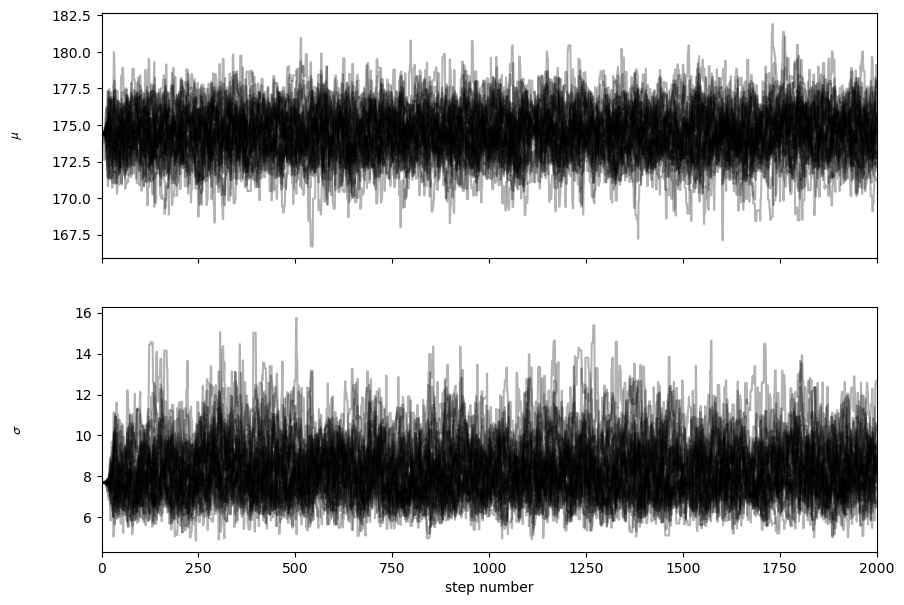

In [268]:
fig, axes = plt.subplots(2, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["$\mu$", "$\sigma$"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");


In [269]:
tau = sampler.get_autocorr_time()
print(tau)

[28.821891   28.67150564]


In [270]:
flat_samples = sampler.get_chain(discard=100, flat=True)
print(flat_samples.shape)

(60800, 2)


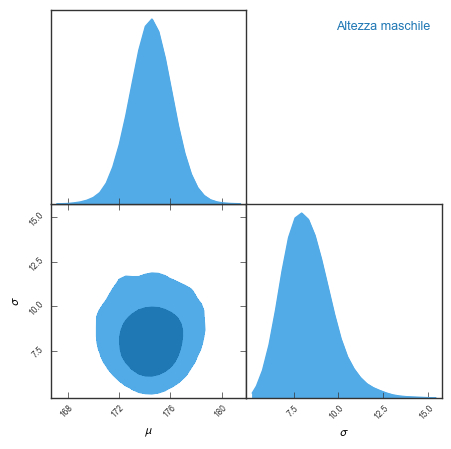

In [271]:
import pygtc
GTC = pygtc.plotGTC(chains=flat_samples,
                    paramNames=['$\mu$','$\sigma$'],
                    chainLabels=['Altezza maschile'],
                    figureSize='MNRAS_page')

## Esercizio 4

La distribuzione di massa stellare di un ammasso di galassie a massa totale fissata $M$ e' descritta da una distribuzione lognormale, con deviazione standard parametro indipendente $ \sigma_{ln M_*} $ . I parametri che descrivono il valor medio

sono:

$$ \mu \equiv ln M_* | ln M_\mathrm{tot} = A + B \, ln M_\mathrm{tot}$$

Vincolare, A, B, $ \sigma_{ln M_*} $



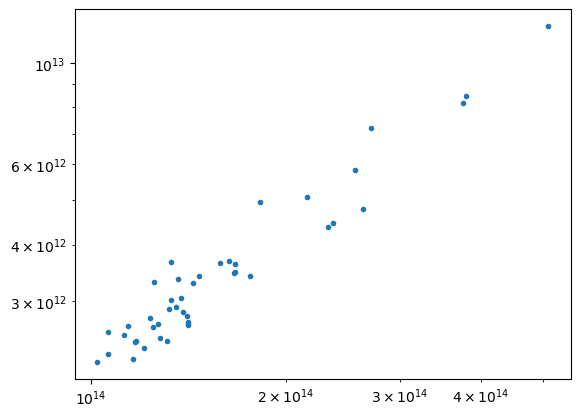

In [272]:
data = pd.read_csv('Esercizio4.csv')
plt.loglog(data["Mass"],data["Mstar"],'.')

In [273]:
def modello(A,B,x):
    return A + B*(x-np.median(x))
#    return A + B*(x)

def log_prior(theta):
    A, B, s = theta
    if s>0:
        return 0
    return -np.inf
    
    
def log_likelihood(theta, x, y):
    A, B, s = theta
    ymod = modello(A,B,x)
    return np.nansum(norm.logpdf(y,loc=ymod,scale=s))

    
    
def log_posterior(theta, x, y):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y)


from scipy.optimize import minimize

X = np.log(data["Mass"])
Y = np.log(data["Mstar"])
Y2 = np.log(data["Mgas"])

np.random.seed(42)
nll = lambda *args: -log_posterior(*args)
initial = np.array([1, 1.,1])*(1+ 0.1 * np.random.randn(3))
soln = minimize(nll, initial, args=(X,Y))
A_bf, B_bf, s_bf = soln.x
print(soln.x)

[28.73797739  1.01724956  0.10343266]


/Users/saro/anaconda3/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/Users/saro/anaconda3/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


In [274]:
pos = soln.x *(1+ 1e-4 * np.random.randn(32, 3))
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_posterior, args=(X,Y)
)
sampler.run_mcmc(pos, 1000, progress=True);

100%|███████████████████████████████████████| 1000/1000 [00:19<00:00, 50.83it/s]


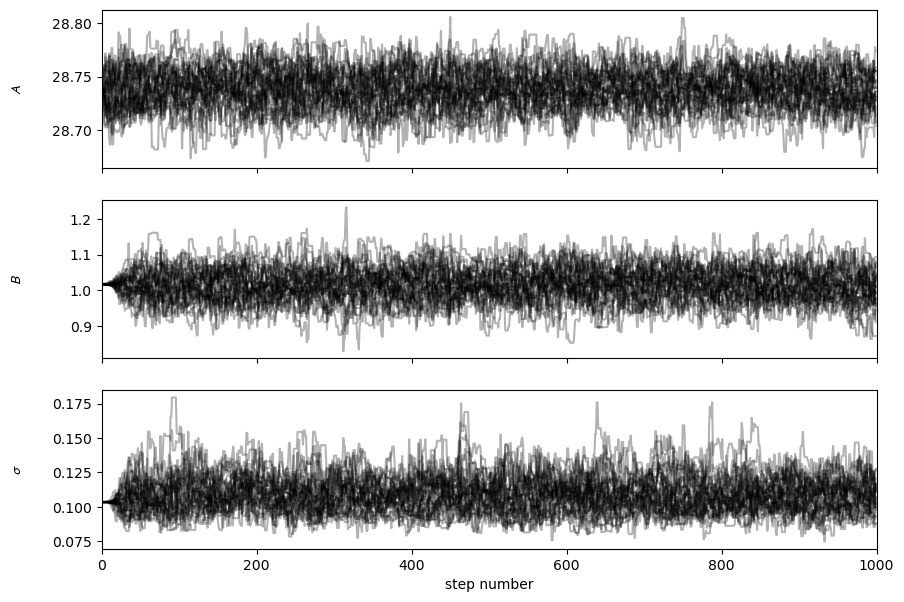

In [275]:
fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["$A$","$B$", "$\sigma$"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");


In [276]:
tau = sampler.get_autocorr_time()
print(tau)

AutocorrError: The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [28.71540664 32.04756436 25.67714004]

In [277]:
flat_samples = sampler.get_chain(discard=100, flat=True)
print(flat_samples.shape)

(28800, 3)


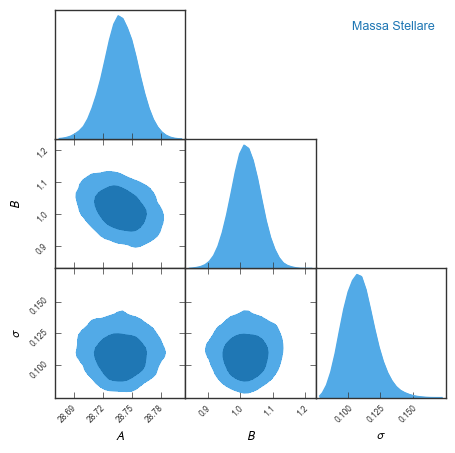

In [278]:
import pygtc
GTC = pygtc.plotGTC(chains=flat_samples,
                    paramNames=['$A$','$B$','$\sigma$'],
                    chainLabels=['Massa Stellare'],
                    figureSize='MNRAS_page')

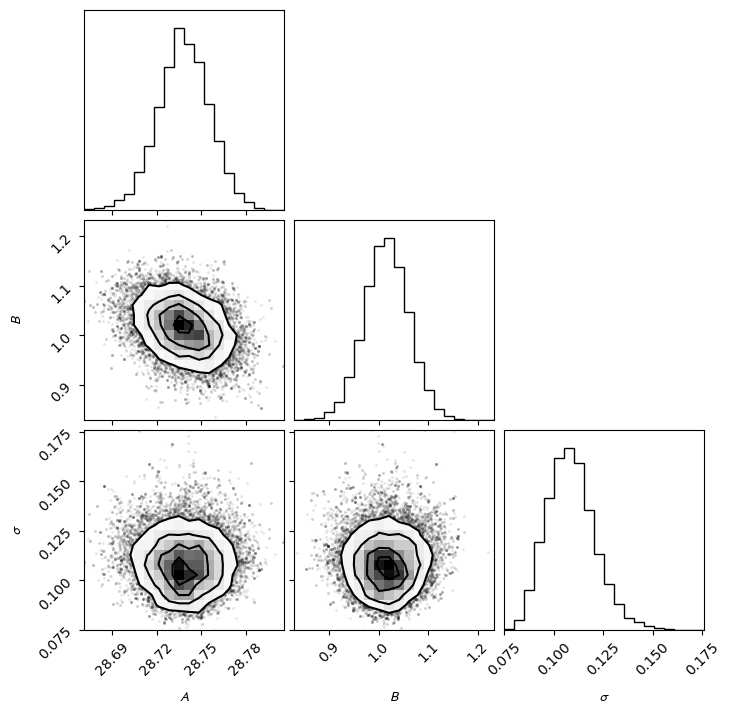

In [279]:
#!pip install corner
import corner

fig = corner.corner(
    flat_samples, labels=["$A$","$B$","$\sigma$"]);

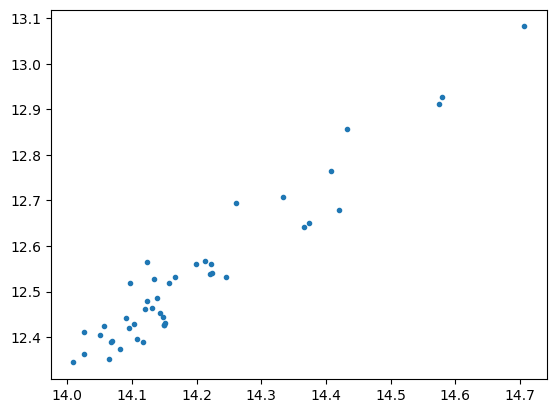

In [280]:
plt.plot(np.log10(data["Mass"]),np.log10(data["Mstar"]),'.')

In [281]:
flat_samples.shape

(28800, 3)

In [282]:
Nsamples =1000
xarr = np.logspace(14,14.8,2000)
yarr = np.zeros((2000,Nsamples))
for i in range(Nsamples):
    theta = flat_samples[np.random.randint(len(flat_samples[:,0])),:]
    yarr[:,i] = theta[0] + theta[1]*(np.log(xarr)-np.median(X))

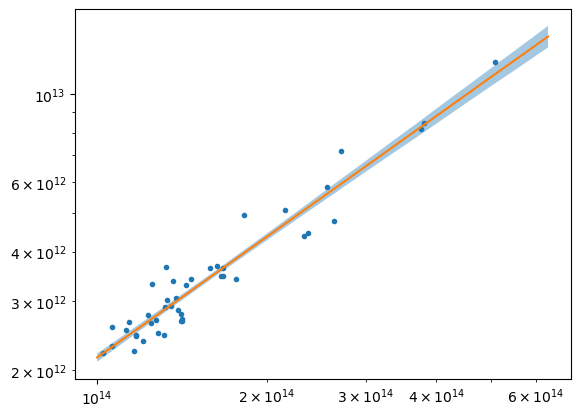

In [283]:
plt.loglog(data["Mass"],data["Mstar"],'.')
plt.plot(xarr,np.exp(np.percentile(yarr,50,axis=1)))
plt.fill_between(xarr,np.exp(np.percentile(yarr,16,axis=1)),np.exp(np.percentile(yarr,84,axis=1)),alpha=0.4)
#plt.fill_between(xarr,np.exp(np.percentile(yarr,50,axis=1)-s_bf),np.exp(np.percentile(yarr,50,axis=1)+s_bf),alpha=0.2)

## Esercizio 5

La distribuzione di massa stellare e massa di gas di un ammasso di galassie a massa totale fissata $M$ e' descritta da distribuzioni lognormale, con deviazione standard parametro indipendente $ \sigma$, possibilmente correlati con coefficiente di correlazione $\rho$. I parametri che descrivono il valor medio

sono:

$$ \mu_1 \equiv ln M_* | ln M_\mathrm{tot} = A_1 + B_1 \, ln M_\mathrm{tot}$$

e

$$ \mu_2 \equiv ln M_\mathrm{gas} | ln M_\mathrm{tot} = A_2 + B_2 \, ln M_\mathrm{tot}$$

Vincolare, $A_1$, $B_1$, $\sigma_1$, $A_2$, $B_2$, $\sigma_2$, e $\rho$.


Text(0, 0.5, 'log (Observed Mass/M$_\\odot$)')

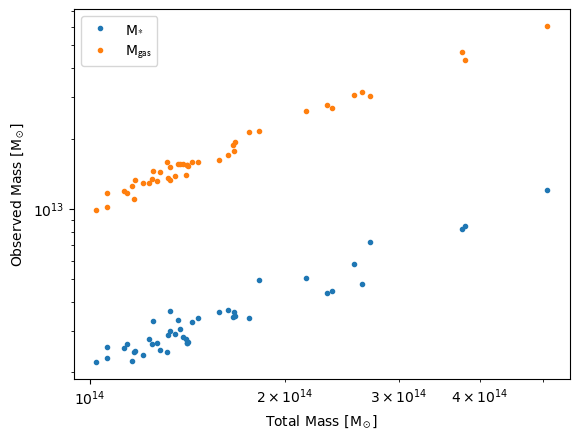

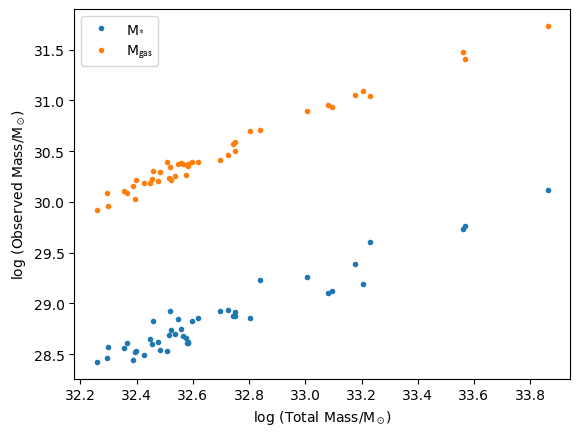

In [284]:
X = np.log(data["Mass"])
Y1 = np.log(data["Mstar"])
Y2 = np.log(data["Mgas"])
plt.figure()
plt.loglog(np.exp(X),np.exp(Y1),'.',label="M$_{*}$")
plt.loglog(np.exp(X),np.exp(Y2),'.',label="M$_\mathrm{gas}$")
plt.legend()
plt.xlabel("Total Mass [M$_\odot$]")
plt.ylabel("Observed Mass [M$_\odot$]")
plt.figure()
plt.plot(X,Y1,'.',label="M$_{*}$")
plt.plot(X,Y2,'.',label="M$_\mathrm{gas}$")
plt.legend()
plt.xlabel("log (Total Mass/M$_\odot$)")
plt.ylabel("log (Observed Mass/M$_\odot$)")

#plt.plot(Y1,Y2,'.')

In [285]:
def loglikelihood(theta, lnmass, obs1, obs2):
    A1, B1, S1, A2,B2,S2,rho = theta
    
    lnmass_norm = lnmass - np.median(lnmass)
    theo1 = A1 + B1*(lnmass_norm)
    theo2 = A2 + B2*(lnmass_norm)
    
    S12 = rho*S1*S2
    TCOV = np.array([[S1**2,S12],[S12,S2**2]])
    iTCOV = np.linalg.inv(TCOV)
  
    residuals = np.array([obs1-theo1,obs2-theo2]).T

    p,_ = TCOV.shape

    #Compute values
    lognormalization = -0.5*(p*np.log(2 * np.pi) +np.log(np.linalg.det(TCOV)))
    exponent = -0.5 * np.sum(residuals@iTCOV*residuals,axis=1)

    return np.nansum(lognormalization + exponent ) 
    

def log_prior(theta):
    A1, B1, S1, A2,B2,S2,rho = theta
    if S1 > 0 and S2 > 0 and -1<rho<1:
        return 0.0
    return -np.inf

def log_probability(theta, lnmass, obs1, obs2 ):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + loglikelihood(theta, lnmass, obs1, obs2)

In [286]:
A1 = 28.
B1 = 1.
S1 = 0.12


A2 = 30.5
B2 = 1.1
S2 = 0.05

rho = 0

theta = [A1, B1, S1, A2,B2,S2,rho]
loglikelihood(theta,X,Y1,Y2)

-931.6529011993049

In [287]:
from scipy.optimize import minimize

np.random.seed(42)
nll = lambda *args: -log_probability(*args)
initial = np.array(theta) 
soln = minimize(nll, initial, args=(X, Y1, Y2))


soln.x, loglikelihood(soln.x,X,Y1,Y2)


/Users/saro/anaconda3/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/Users/saro/anaconda3/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/Users/saro/anaconda3/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/Users/saro/anaconda3/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/Users/saro/anaconda3/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


(array([28.73797739,  1.01724957,  0.10343266, 30.34849127,  1.11761012,
         0.05435921, -0.08956901]),
 103.27353964499567)

In [288]:
import emcee

nparams = len(theta)

pos = soln.x * (1+1e-4 * np.random.randn(32,nparams ))
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(X, Y1, Y2)
)
sampler.run_mcmc(pos, 2000, progress=True);

100%|███████████████████████████████████████| 2000/2000 [01:00<00:00, 32.90it/s]


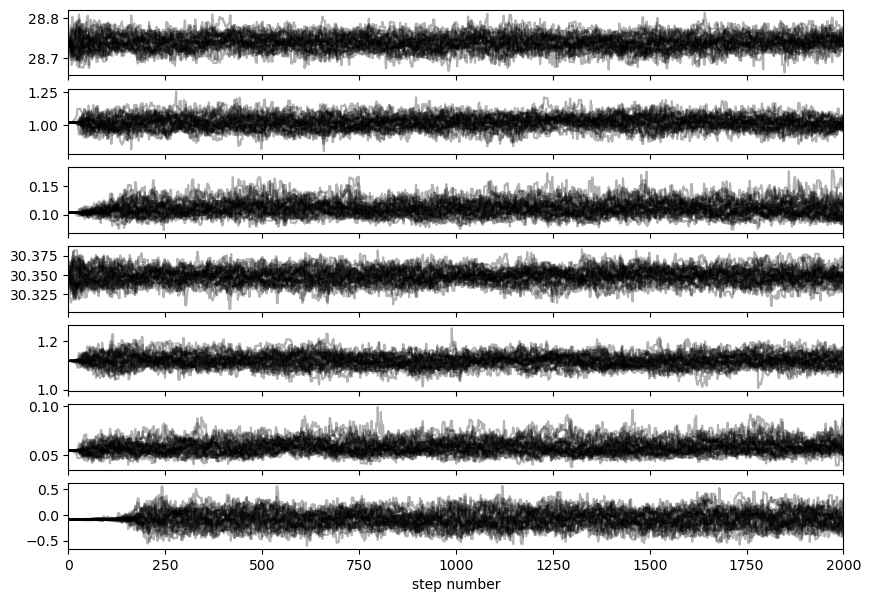

In [289]:
fig, axes = plt.subplots(7, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");


In [290]:
tau = sampler.get_autocorr_time()
print(tau)

AutocorrError: The chain is shorter than 50 times the integrated autocorrelation time for 7 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 40;
tau: [64.34092867 61.90189217 71.42311078 61.50952123 62.20163461 65.77193696
 59.83020818]

In [293]:
flat_samples = sampler.get_chain(discard=200, flat=True)


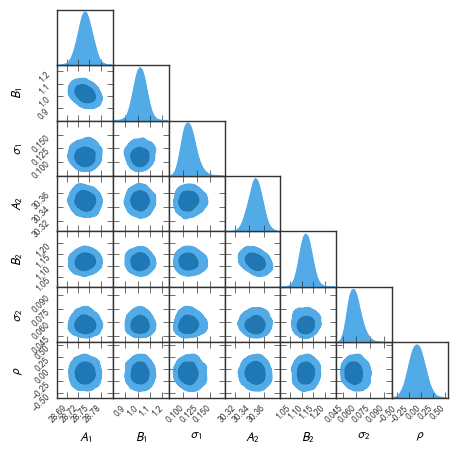

In [294]:
GTC = pygtc.plotGTC(chains=flat_samples,
                    paramNames=['$A_1$','$B_1$','$\sigma_1$','$A_2$','$B_2$','$\sigma_2$','$\\rho$'],
                    figureSize='MNRAS_page')

## Esercizio 6

Analizzare i dati delle supernove della collaborazione Pantheon+SH0ES e vincolare i parametri cosmologici. 

https://github.com/PantheonPlusSH0ES/PantheonPlusSH0ES.github.io


https://github.com/PantheonPlusSH0ES/DataRelease

#!wget https://raw.githubusercontent.com/PantheonPlusSH0ES/DataRelease/main/Pantheon%2B_Data/4_DISTANCES_AND_COVAR/Pantheon%2BSH0ES.dat

#!wget https://raw.githubusercontent.com/PantheonPlusSH0ES/DataRelease/main/Pantheon%2B_Data/4_DISTANCES_AND_COVAR/Pantheon%2BSH0ES_STAT%2BSYS.cov

#!wget https://raw.githubusercontent.com/PantheonPlusSH0ES/DataRelease/main/Pantheon%2B_Data/4_DISTANCES_AND_COVAR/Pantheon%2BSH0ES_STATONLY.cov

# Supernove di Tipo Ia e Cosmologia

Le supernove di tipo Ia (SNe Ia) sono eventi astronomici di grande importanza nella cosmologia, in particolare per la misurazione delle distanze cosmiche e lo studio dell'espansione dell'universo.

## Caratteristiche delle Supernove Ia

- **"Candele Standard"**: Le SNe Ia sono considerate come candele standard (o meglio standardizzabili) nell'universo. Questo significa che hanno una luminosità intrinseca molto simile, permettendo agli astronomi di utilizzarle per misurare le distanze cosmiche.
- **Processo di Formazione**: Si formano in sistemi binari dove una nana bianca accumula materia da una stella compagna fino a raggiungere una massa critica, innescando una reazione nucleare che porta all'esplosione della supernova.

In [295]:
from IPython.display import Video
# Inserisci l'URL del video
Video("https://svs.gsfc.nasa.gov/vis/a020000/a020300/a020344/IA_Acc_4k_60fps_h264.mp4",width=560)

## Magnitudini Osservate e Cosmologia

- **Legge di Hubble**: Le SNe Ia hanno avuto un ruolo cruciale nella scoperta dell'espansione accelerata dell'universo. La relazione tra la distanza di una supernova e la sua velocità di allontanamento, derivata dalla legge di Hubble, è stata fondamentale per questa scoperta.
- **Energia Oscura**: Le osservazioni delle SNe Ia hanno portato all'ipotesi dell'esistenza dell'energia oscura, una forma di energia che permea lo spazio e accelera l'espansione dell'universo.

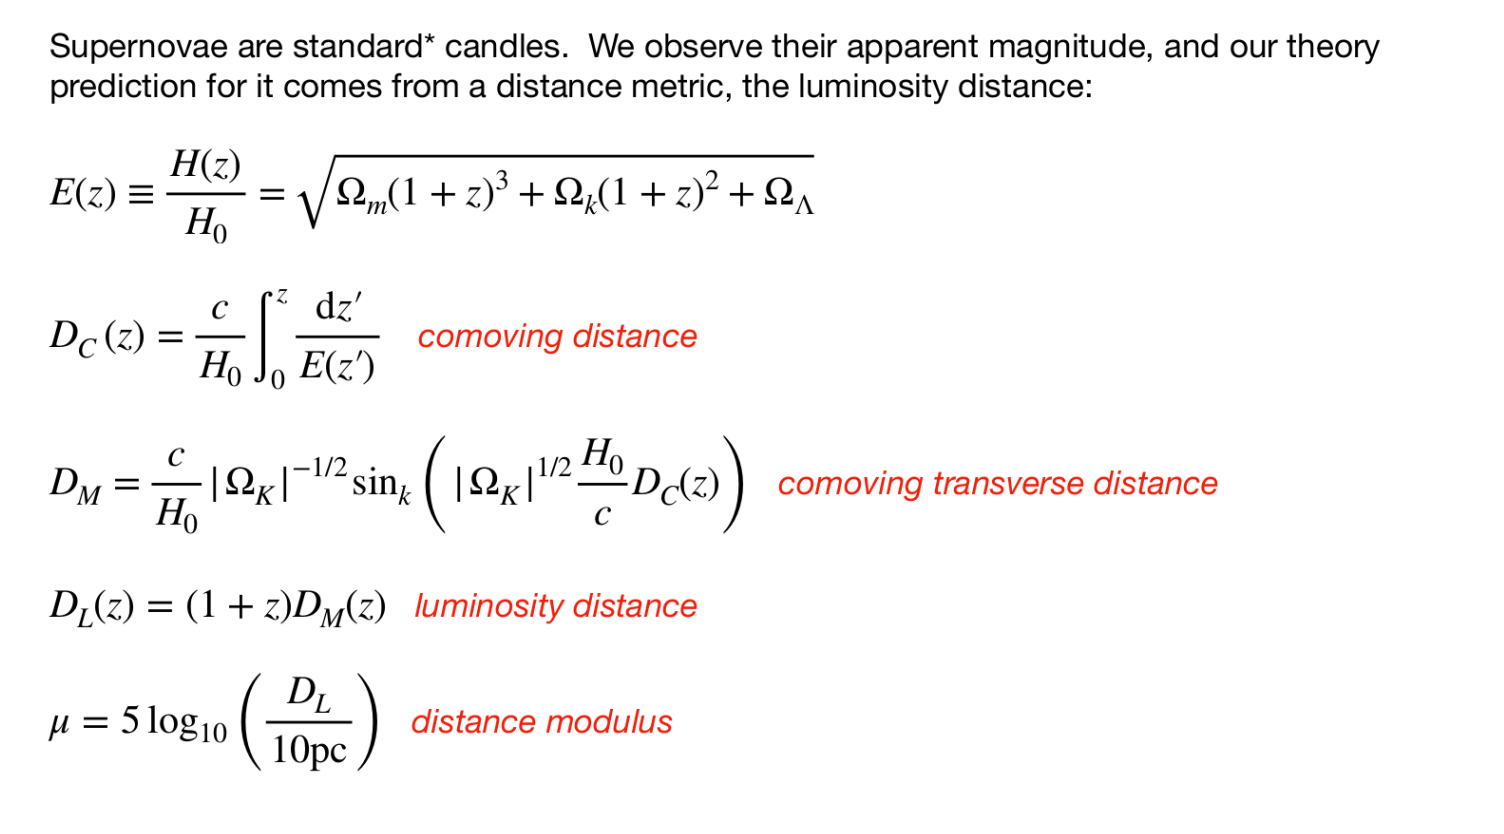

And $\Omega_k + \Omega_\Lambda + \Omega_M = 1$ 

La magnitudine osservata standardizzata e' il modulo di distanza a meno di una costante $M$ da calibrare.

In [311]:
from astropy.table import Table
from astropy import cosmology

Text(0, 0.5, '$M_b$ [mag]')

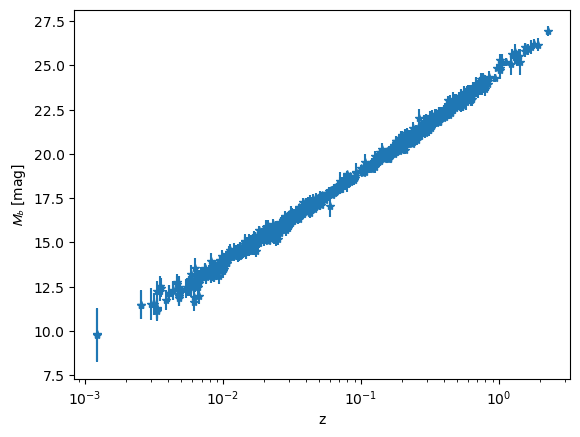

In [312]:
df = Table.read("~admin/Downloads/Pantheon+SH0ES.dat", format="ascii")
plt.errorbar(df['zHD'], df['m_b_corr'], yerr=df['m_b_corr_err_DIAG'], fmt='*')
plt.xscale('log')
plt.xlabel('z')
plt.ylabel('$M_b$ [mag]')

Text(0, 0.5, '$M_b$ [mag]')

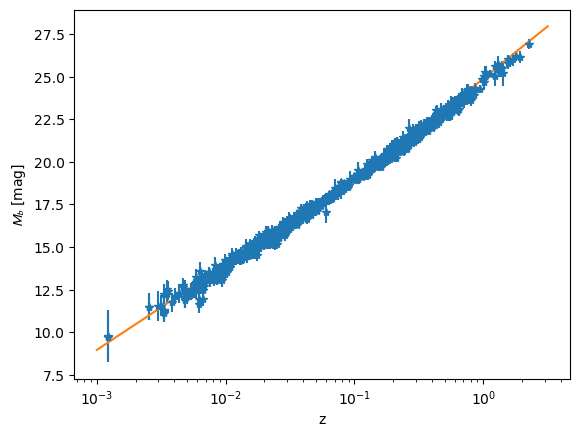

In [313]:
OmegaM = 0.3
OmegaL = 0.7
H0 = 70.
M = -10.8



cosmo = cosmology.LambdaCDM(H0, OmegaM, OmegaL)

zz = np.logspace(-3, 0.5)

dL = cosmo.luminosity_distance(zz).value
    
dist_mod = 5*np.log10(dL/10)


plt.errorbar(df['zHD'], df['m_b_corr'], yerr=df['m_b_corr_err_DIAG'], fmt='*')
plt.plot(zz, dist_mod-M)
plt.xscale('log')
plt.xlabel('z')
plt.ylabel('$M_b$ [mag]')



In [314]:
def cov_reader(filename):
    tmp = np.genfromtxt(filename)
    ndim = int(tmp[0])
    cov = tmp[1:].reshape(ndim, ndim)
    return cov

cov_stat = cov_reader('/Users/admin/Downloads/Pantheon+SH0ES_STATONLY.cov')
cov_tot = cov_reader('/Users/admin/Downloads/Pantheon+SH0ES_STAT+SYS.cov')

<Figure size 640x480 with 0 Axes>

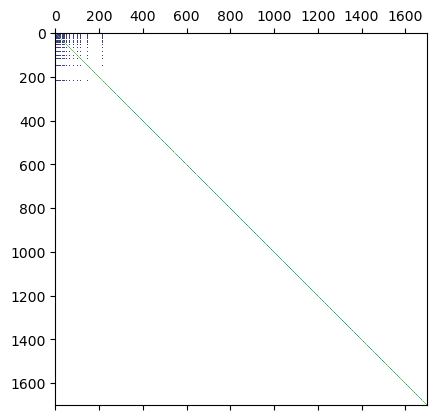

<Figure size 640x480 with 0 Axes>

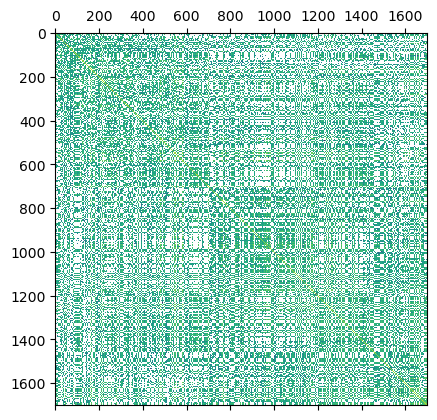

In [315]:
from matplotlib.colors import LogNorm

plt.figure()
plt.matshow(cov_stat, norm=LogNorm())

plt.figure()
plt.matshow(cov_tot, norm=LogNorm())

In [316]:
TCOV = cov_tot
iTCOV = np.linalg.inv(TCOV)


def log_prior(theta):
    OmegaM, OmegaL, M = theta
    if 0 <= OmegaM < 2 and 0.0 <= OmegaL < 2.0:
        return 0.0
    return -np.inf


def log_likelihood(theta, zs, mus, cov, H0=70):
    OmegaM, OmegaL, M = theta
    cosmo = cosmology.LambdaCDM(H0=H0, Om0=OmegaM, Ode0=OmegaL)
    
    dL = cosmo.luminosity_distance(zs).value
    dist_mod = 5*np.log10(dL/10)
    residuals = np.array([mus-dist_mod + M])

    p,_ = TCOV.shape
    exponent = -(1/2) * np.sum(residuals@iTCOV*residuals,axis=1)

    return np.nansum(exponent )

def log_probability(theta, zs, mus, cov):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, zs, mus, TCOV)

In [317]:
theta = np.array([0.3, 0.6, -10.65])
%time print(log_probability(theta, df['zHD'], df['m_b_corr'], TCOV))

-877.8455798670657
CPU times: user 22.4 ms, sys: 2.46 ms, total: 24.9 ms
Wall time: 5.98 ms


In [318]:
pos = theta + 0.1 * np.random.randn(12, 3)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=( df['zHD'], df['m_b_corr'], TCOV)
)
sampler.run_mcmc(pos, 1000, progress=True);

100%|███████████████████████████████████████| 1000/1000 [00:55<00:00, 18.05it/s]


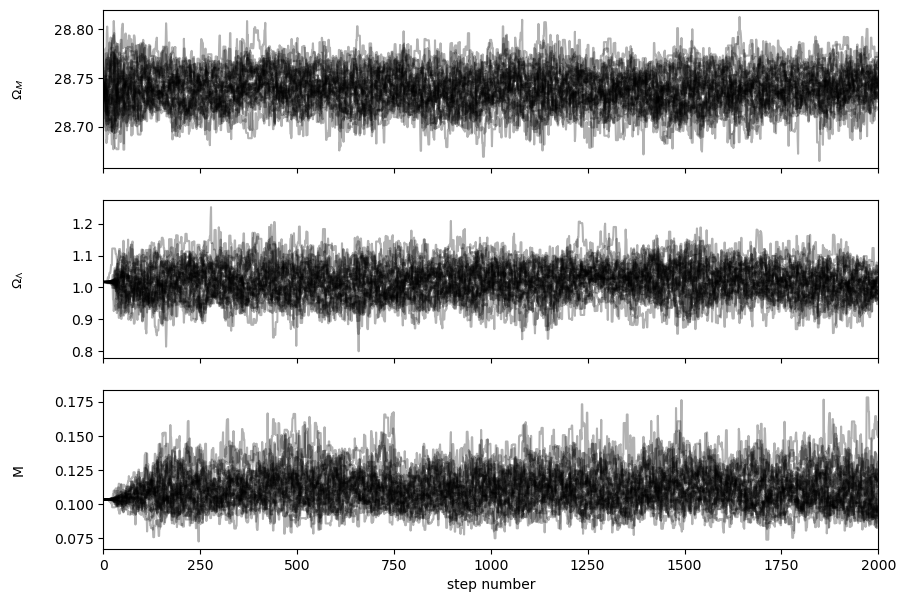

In [319]:
fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
labels = [r"$\Omega_M$", r"$\Omega_\Lambda$", "M"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [320]:
np.save('/Users/admin/Downloads/big_chain', sampler.get_chain())
samples = np.load('/Users/admin/Downloads/big_chain.npy')

(10800, 3)


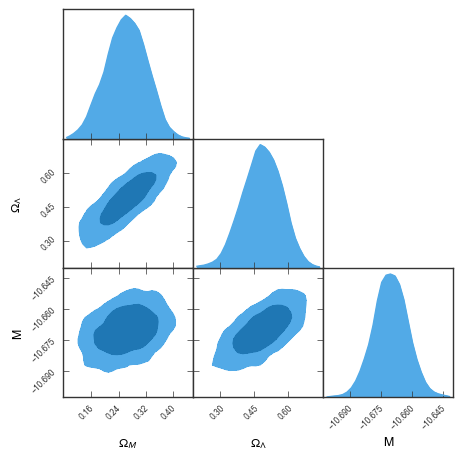

In [321]:
converged = samples[100:].reshape(-1, 3)
print(converged.shape)

GTC = pygtc.plotGTC(chains=converged,
                    paramNames=labels,
                    figureSize='MNRAS_page',
                    plotName='/Users/admin/Downloads/fullGTC.pdf')

0.2543475701936029 0.13854363163959257


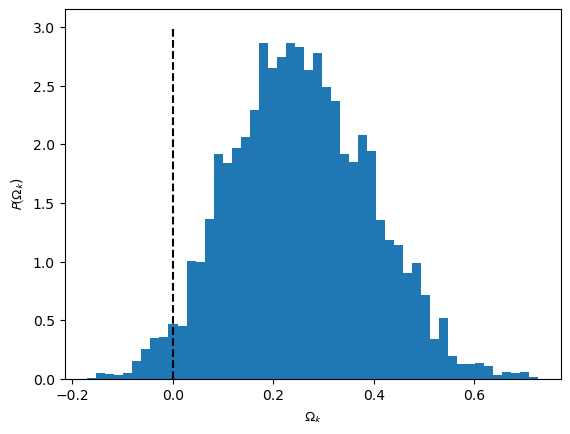

In [322]:
# posterior predictions

# curvature

OmegaK = 1 - converged[:, 0] - converged[:, 1]

plt.hist(OmegaK, bins=50, density=True)
print(np.mean(OmegaK), np.std(OmegaK))
plt.xlabel("$\Omega_k$")
plt.ylabel("$P(\Omega_k$)")
plt.vlines(0,0,3, colors="black", linestyles="dashed")

# flatness compatible at ~2 sigma....